# Import dependencies

In [1]:
import tensorflow as tf
import pandas as pd
from keras import backend as K
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
import cv2
import dlib

In [4]:
import imageio

In [6]:
import os
import random

In [7]:
from typing import List

# GPU setup

In [8]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Dlib

In [13]:
hog_face_detector = dlib.get_frontal_face_detector()

dlib_facelandmark = dlib.shape_predictor("./predictor/shape_predictor_68_face_landmarks.dat")

# Data loading

In [9]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [45]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        faces = hog_face_detector(frame.numpy())
        for face in faces:
            face_landmarks = dlib_facelandmark(frame.numpy(), face)

            lips = []

            for n in range(48, 68):
                x = face_landmarks.part(n).x
                y = face_landmarks.part(n).y
                lips.append([x, y])
	
        lips = np.array(lips)
        centroid = np.mean(lips, axis = 0)
        start_point = (int(centroid[0] - 100 // 2), int(centroid[1] - 30 // 2))
        end_point = (int(centroid[0] + 100 // 2), int(centroid[1] + 30 // 2))
        frames.append(frame[start_point[1]:end_point[1],start_point[0]:end_point[0],:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [11]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [12]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


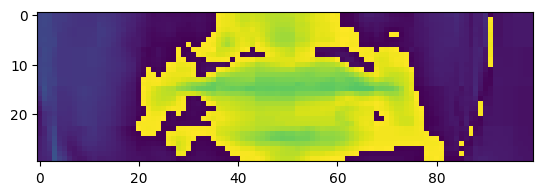

In [54]:
plt.imshow(load_video('.\\data\\s1\\bbal6n.mpg')[0].numpy())